<a href="https://colab.research.google.com/github/cylyu/ist718-project/blob/main/geo_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
pip install pyspark
# Download tweets.csv from github
# If the tweets.csv file does not exist in the colab environment
if [[ ! -f ./nyc-rolling-sales.csv ]]; then 
   # download tweets.csv file from github and save it in this colab environment instance
   wget https://github.com/cylyu/ist718-project/blob/main/nyc-rolling-sales.csv   
fi

# vefify tweets.csv exits in the colab env - should not print an error message
ls nyc-rolling-sales.csv

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=6b8f5c7dfc901c0dff50059fb27011fd86dea009fef26f82aa110c381d04c6a3
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
nyc-rolling-sales.csv


--2020-11-28 05:43:19--  https://github.com/cylyu/ist718-project/blob/main/nyc-rolling-sales.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘nyc-rolling-sales.csv’

     0K .......... .......... .......... .......... .......... 2.89M
    50K .......... .......... .......... .......... ...        5.84M=0.02s

2020-11-28 05:43:19 (3.78 MB/s) - ‘nyc-rolling-sales.csv’ saved [95731]



In [ ]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
from pyspark.sql import types
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,lower
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler,PCA
from pyspark.sql.functions import concat, concat_ws
import pandas as pd
from pyspark.sql.types import DoubleType,IntegerType,TimestampType,DateType, StringType
spark = SparkSession.builder.master("local[*]").config("spark.memory.fraction", 0.8).config("spark.executor.memory", "12g").config("spark.driver.memory", "12g").config("spark.memory.offHeap.enabled",'true').config("spark.memory.offHeap.size","12g").getOrCreate()
sparkContext=spark.sparkContext
from pyspark.sql.functions import year, month, dayofmonth

In [ ]:
nyc_rolling_sales_df = spark.read.csv("nyc-rolling-sales.csv", header=True, inferSchema=True)
nyc_rolling_sales_df=nyc_rolling_sales_df.withColumnRenamed('APARTMENT NUMBER','apartment_number').withColumnRenamed('SALE PRICE','sale_price').\
withColumnRenamed('SALE DATE','sale_date').\
withColumnRenamed('BUILDING CLASS AT TIME OF SALE','building_class_at_sale').\
withColumnRenamed('ZIP CODE','zipcode').\
withColumnRenamed('GROSS SQUARE FEET','gross_square_feet').\
withColumnRenamed('LAND SQUARE FEET','land_square_feet').\
withColumnRenamed('BOROUGH','borough').\
withColumn('borough',fn.when(fn.col('borough')==1,'Manhatten').\
                                                     when(fn.col('borough')==2,'Bronx').\
                                                     when(fn.col('borough')==3,'Brooklyn').\
                                                     when(fn.col('borough')==4,'Queens').\
                                                     when(fn.col('borough')==5,'Staten Island').\
                                                     otherwise(fn.col("borough")))


nyc_rolling_sales_df=nyc_rolling_sales_df.filter(nyc_rolling_sales_df.sale_price != ' -  ').\
                     filter(nyc_rolling_sales_df.land_square_feet != ' -  ').\
                     filter(nyc_rolling_sales_df.gross_square_feet != ' -  ').\
                     withColumn("sale_price",nyc_rolling_sales_df["sale_price"].cast(IntegerType())).\
                     withColumn("gross_square_feet",nyc_rolling_sales_df["gross_square_feet"].cast(IntegerType())).\
                     withColumn("sale_date",nyc_rolling_sales_df["sale_date"].cast(DateType())).\
                     withColumn("land_square_feet",nyc_rolling_sales_df["land_square_feet"].cast(IntegerType())).\
                     withColumn("price_per_sq_ft", col("sale_price") / col("gross_square_feet"))




date_df=nyc_rolling_sales_df.select("sale_date",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
).\
withColumn('month',fn.when(fn.col('month')==1,'Jan').\
                                                     when(fn.col('month')==2,'Fed').\
                                                     when(fn.col('month')==3,'Mar').\
                                                     when(fn.col('month')==4,'Apr').\
                                                     when(fn.col('month')==5,'Mar').\
                                                     when(fn.col('month')==6,'Jun').\
                                                     when(fn.col('month')==7,'Jul').\
                                                     when(fn.col('month')==8,'Aug').\
                                                     when(fn.col('month')==9,'Sep').\
                                                     when(fn.col('month')==10,'Oct').\
                                                     when(fn.col('month')==11,'Nov').\
                                                     when(fn.col('month')==12,'Dec').\
                                                     otherwise(fn.col("month")))

nyc_rolling_sales_date_df=nyc_rolling_sales_df.join(date_df,nyc_rolling_sales_df.sale_date == date_df.sale_date, how="left")
nyc_rolling_sales_pd=nyc_rolling_sales_df.toPandas()

In [ ]:
nyc_rolling_sales_filter_df=nyc_rolling_sales_df.\
filter(nyc_rolling_sales_df.sale_price>=100000).\
filter(nyc_rolling_sales_df.sale_price<=5000000)

Spot trends in the property market, in association with affairs in 2016 and 2017 which may have effect on property sales.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


ConversionError: ignored

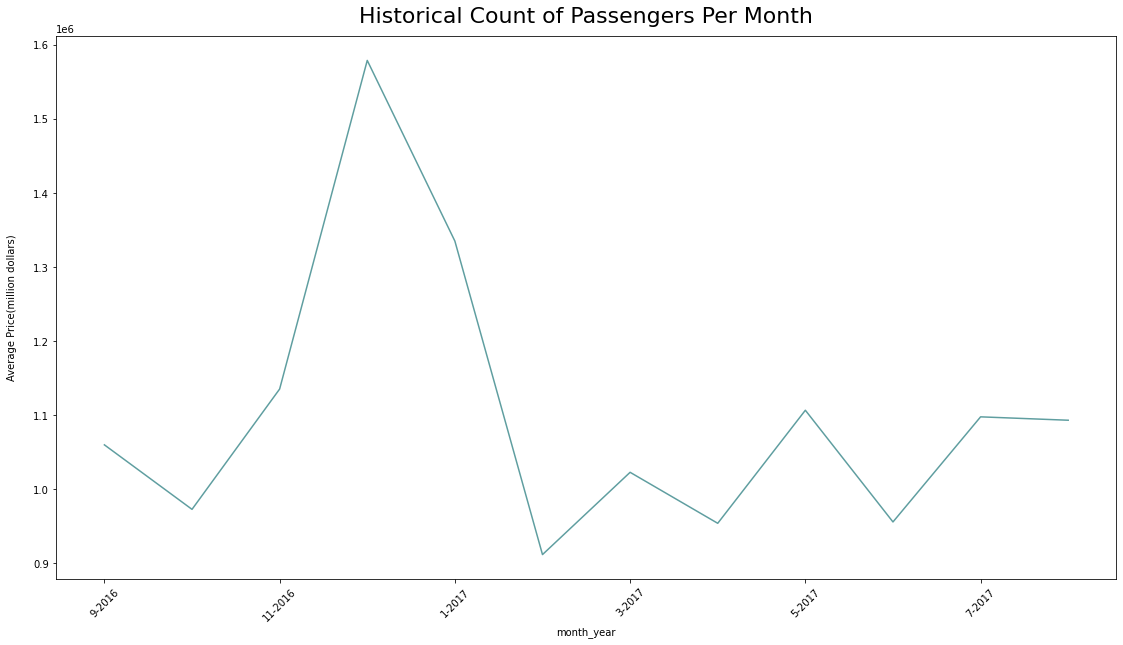

In [ ]:

date_df=nyc_rolling_sales_df.select("sale_date",
                                    "sale_price",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)
# .\
# withColumn('month',fn.when(fn.col('month')==1,'Jan').\
#                                                      when(fn.col('month')==2,'Fed').\
#                                                      when(fn.col('month')==3,'Mar').\
#                                                      when(fn.col('month')==4,'Apr').\
#                                                      when(fn.col('month')==5,'Mar').\
#                                                      when(fn.col('month')==6,'Jun').\
#                                                      when(fn.col('month')==7,'Jul').\
#                                                      when(fn.col('month')==8,'Aug').\
#                                                      when(fn.col('month')==9,'Sep').\
#                                                      when(fn.col('month')==10,'Oct').\
#                                                      when(fn.col('month')==11,'Nov').\
#                                                      when(fn.col('month')==12,'Dec').\
#                                                      otherwise(fn.col("month")))
                                                
b=date_df.groupBy('month','year').avg('sale_price')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year))
b_pd=b.toPandas().sort_values(['year', 'month'], ascending=[True, True])




b_pd.set_index('month_year')['avg(sale_price)'].plot(kind='line',
                                                                                figsize=(19, 10),
                                                                                 color='cadetblue',
                                                                                rot=45)
plt.title("Historical Count of Passengers Per Month", y=1.013, fontsize=22)
axes= plt.axes()
plt.ylabel("Average Price(million dollars)", labelpad=16)
axes.set_xticks(b_pd['month_year'])
plt.xlabel("Date [Month - Year]", labelpad=16); 




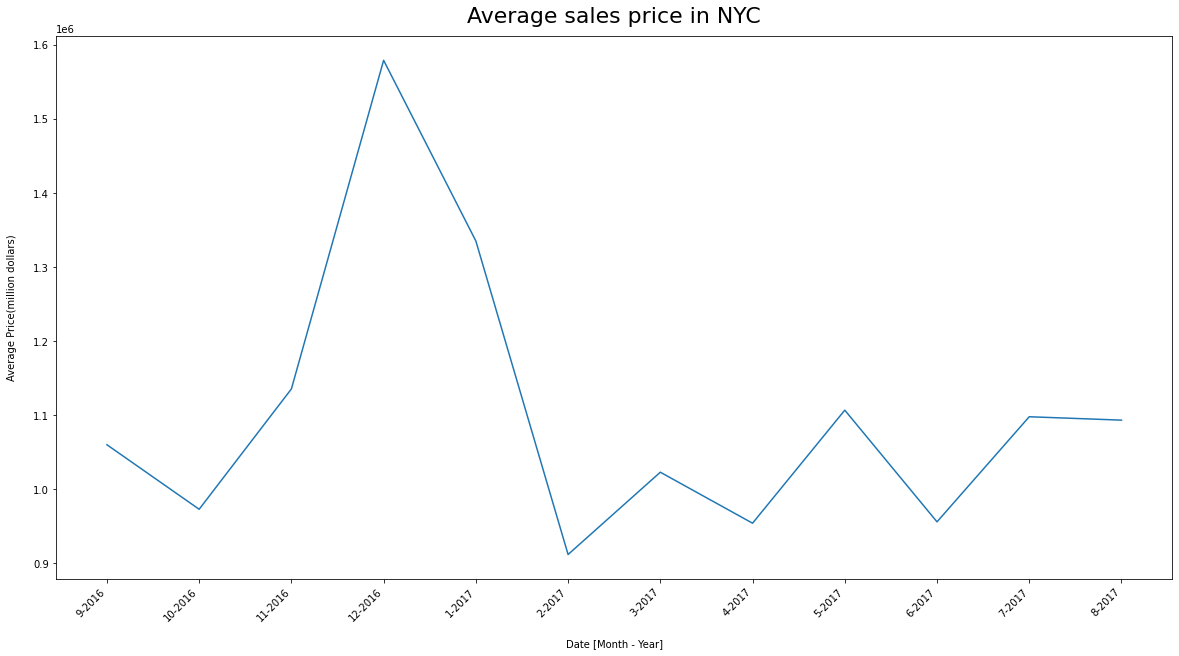

In [ ]:

date_df=nyc_rolling_sales_df.select("sale_date",
                                    "sale_price",
    year("sale_date").alias('year'), 
    month("sale_date").alias('month'), 
    dayofmonth("sale_date").alias('day')
)
# .\
# withColumn('month',fn.when(fn.col('month')==1,'Jan').\
#                                                      when(fn.col('month')==2,'Fed').\
#                                                      when(fn.col('month')==3,'Mar').\
#                                                      when(fn.col('month')==4,'Apr').\
#                                                      when(fn.col('month')==5,'Mar').\
#                                                      when(fn.col('month')==6,'Jun').\
#                                                      when(fn.col('month')==7,'Jul').\
#                                                      when(fn.col('month')==8,'Aug').\
#                                                      when(fn.col('month')==9,'Sep').\
#                                                      when(fn.col('month')==10,'Oct').\
#                                                      when(fn.col('month')==11,'Nov').\
#                                                      when(fn.col('month')==12,'Dec').\
#                                                      otherwise(fn.col("month")))
                                                
b=date_df.groupBy('month','year').avg('sale_price')
b=b.withColumn("month_year", concat_ws("-",  b.month,b.year))
b_pd=b.toPandas().sort_values(['year', 'month'], ascending=[True, True])
names = b_pd['month_year']
values =b_pd['avg(sale_price)']

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(names, values)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel("Average Price(million dollars)", labelpad=16)

plt.xlabel("Date [Month - Year]", labelpad=16)
plt.title("Average sales price in NYC", y=1.013, fontsize=22)
plt.show()


# b_pd.set_index('month_year')['avg(sale_price)'].plot(kind='line',
#                                                                                 figsize=(19, 10),
#                                                                                  color='cadetblue',
#                                                                                 rot=45)
# plt.title("Historical Count of Passengers Per Month", y=1.013, fontsize=22)
# axes= plt.axes()


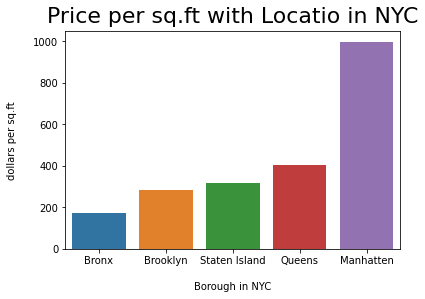

In [ ]:
borough_data=nyc_rolling_sales_date_df.groupby('borough').avg('price_per_sq_ft').toPandas().sort_values('avg(price_per_sq_ft)')
sns.barplot(x = 'borough',
            y='avg(price_per_sq_ft)',
              data=borough_data
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Borough in NYC", labelpad=16)
plt.title("Price per sq.ft with Locatio in NYC", y=1.013, fontsize=22)
plt.show()



In [ ]:
neighborhood_data=nyc_rolling_sales_date_df.filter(nyc_rolling_sales_df.price_per_sq_ft >=10000).groupby('NEIGHBORHOOD','borough').avg('price_per_sq_ft')
neighborhood_pd=neighborhood_data.withColumn("neigbor", concat_ws(" ",  neighborhood_data.borough,neighborhood_data.NEIGHBORHOOD)).toPandas().sort_values('avg(price_per_sq_ft)')

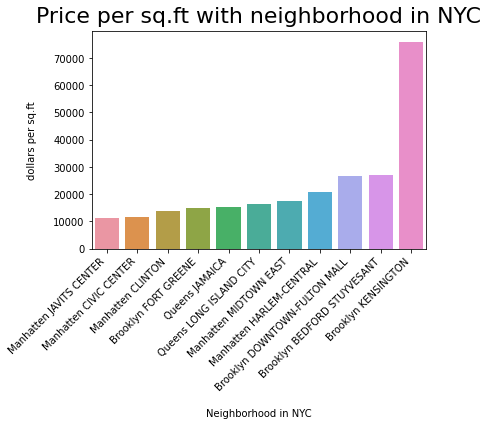

In [ ]:
sns.barplot(x = 'neigbor',
            y='avg(price_per_sq_ft)',
              data=neighborhood_pd
)
plt.ylabel("dollars per sq.ft", labelpad=16)

plt.xlabel("Neighborhood in NYC", labelpad=16)
plt.title("Price per sq.ft with neighborhood in NYC", y=1.013, fontsize=22)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

In [ ]:
display(neighborhood_pd)

,NEIGHBORHOOD,borough,avg(price_per_sq_ft),neigbor
3,JAVITS CENTER,Manhatten,11084.444444,Manhatten JAVITS CENTER
1,CIVIC CENTER,Manhatten,11791.666667,Manhatten CIVIC CENTER
8,CLINTON,Manhatten,13988.095238,Manhatten CLINTON
6,FORT GREENE,Brooklyn,14800.000000,Brooklyn FORT GREENE
2,JAMAICA,Queens,15333.333333,Queens JAMAICA
10,LONG ISLAND CITY,Queens,16457.873250,Queens LONG ISLAND CITY
0,MIDTOWN EAST,Manhatten,17338.709677,Manhatten MIDTOWN EAST
4,HARLEM-CENTRAL,Manhatten,20962.732919,Manhatten HARLEM-CENTRAL
9,DOWNTOWN-FULTON MALL,Brooklyn,26585.660117,Brooklyn DOWNTOWN-FULTON MALL
7,BEDFORD STUYVESANT,Brooklyn,27083.333333,Brooklyn BEDFORD STUYVESANT


In [ ]:
neighborhood_data=nyc_rolling_sales_date_df.filter(nyc_rolling_sales_df.price_per_sq_ft <= 10).groupby('NEIGHBORHOOD','borough').avg('price_per_sq_ft').show()

+--------------------+-------------+--------------------+
|        NEIGHBORHOOD|      borough|avg(price_per_sq_ft)|
+--------------------+-------------+--------------------+
|UPPER WEST SIDE (...|    Manhatten| 0.13735816216853053|
|             FORDHAM|        Bronx|6.599706817730068E-4|
|            WOODLAWN|        Bronx|1.539973512455577E-4|
|HIGHBRIDGE/MORRIS...|        Bronx|0.026250501996027614|
|         BROWNSVILLE|     Brooklyn| 0.16336433077327214|
|       MANOR HEIGHTS|Staten Island| 0.04872501483227704|
|           FIELDSTON|        Bronx|                 0.0|
|         GRYMES HILL|Staten Island|    0.64103156959891|
|            NEW DORP|Staten Island|0.004947916666666655|
| DONGAN HILLS-COLONY|Staten Island|0.009267840593141834|
|SCHUYLERVILLE/PEL...|        Bronx|8.352790224613756E-5|
|           REGO PARK|       Queens| 0.10062227987957807|
|          BATH BEACH|     Brooklyn| 0.08181888320459238|
|          MILL BASIN|     Brooklyn|3.022945278501175...|
|      FLUSHIN

In [ ]:
display(b.toPandas())

,month,year,avg(sale_price)
0,1,2017,1.335039e+06
1,3,2017,1.022812e+06
2,11,2016,1.135246e+06
3,6,2017,9.557890e+05
4,7,2017,1.097697e+06
5,8,2017,1.093122e+06
6,10,2016,9.727879e+05
7,12,2016,1.578978e+06
8,2,2017,9.116993e+05
9,9,2016,1.059889e+06


In [ ]:
from pyspark.sql.types import DoubleType
nyc_rolling_sales_df.withColumn("sale_price",nyc_rolling_sales_df["sale_price"].cast(DoubleType()))

DataFrame[_c0: int, borough: int, NEIGHBORHOOD: string, BUILDING CLASS CATEGORY: string, TAX CLASS AT PRESENT: string, BLOCK: int, LOT: int, EASE-MENT: string, BUILDING CLASS AT PRESENT: string, ADDRESS: string, apartment_number: string, zipcode: int, RESIDENTIAL UNITS: int, COMMERCIAL UNITS: int, TOTAL UNITS: int, land_square_feet: string, gross_square_feet: string, YEAR BUILT: int, TAX CLASS AT TIME OF SALE: int, building_class_at_sale: string, sale_price: double, sale_date: string]

In [ ]:
nyc_rolling_sales_df.withColumnRenamed('APARTMENT NUMBER','APARTMENT_NUMBER')

,_c0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [ ]:
nyc_rolling_sales_date_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- NEIGHBORHOOD: string (nullable = true)
 |-- BUILDING CLASS CATEGORY: string (nullable = true)
 |-- TAX CLASS AT PRESENT: string (nullable = true)
 |-- BLOCK: integer (nullable = true)
 |-- LOT: integer (nullable = true)
 |-- EASE-MENT: string (nullable = true)
 |-- BUILDING CLASS AT PRESENT: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- apartment_number: string (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- RESIDENTIAL UNITS: integer (nullable = true)
 |-- COMMERCIAL UNITS: integer (nullable = true)
 |-- TOTAL UNITS: integer (nullable = true)
 |-- land_square_feet: integer (nullable = true)
 |-- gross_square_feet: integer (nullable = true)
 |-- YEAR BUILT: integer (nullable = true)
 |-- TAX CLASS AT TIME OF SALE: integer (nullable = true)
 |-- building_class_at_sale: string (nullable = true)
 |-- sale_price: integer (nullable = true)
 |-- sale_date: date (nullable

In [ ]:
# nyc_rolling_sales_df.na.drop(subset=['SALE PRICE']).show()
nyc_rolling_sales_df.na.drop(subset=['GROSS SQUARE FEET']).show()

AnalysisException: ignored

In [ ]:
df = nyc_rolling_sales_pd[nyc_rolling_sales_pd['sale_price'].notnull()] 

In [ ]:
df.sale_price[1]

3936272.0

In [ ]:
nyc_rolling_sales_df.na.drop(subset=["SALE PRICE"])

DataFrame[_c0: int, BOROUGH: int, NEIGHBORHOOD: string, BUILDING CLASS CATEGORY: string, TAX CLASS AT PRESENT: string, BLOCK: int, LOT: int, EASE-MENT: string, BUILDING CLASS AT PRESENT: string, ADDRESS: string, APARTMENT NUMBER: string, ZIP CODE: int, RESIDENTIAL UNITS: int, COMMERCIAL UNITS: int, TOTAL UNITS: int, LAND SQUARE FEET: string, GROSS SQUARE FEET: string, YEAR BUILT: int, TAX CLASS AT TIME OF SALE: int, BUILDING CLASS AT TIME OF SALE: string, SALE PRICE: string, SALE DATE: string]